# Early decoding

In [15]:
import torch
import numpy as np
from collections import defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from measureLM import helpers

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [1]:
import torch
import transformer_lens
from functools import partial
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  

model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


In [11]:
def encode(texts, model):
    if model.tokenizer.pad_token is None: ## some tokenizers do not have pad tokens
        model.tokenizer.pad_token = model.tokenizer.eos_token  
    tokens = model.to_tokens(texts, prepend_bos=False)
    logits, activs = model.run_with_cache(tokens)
    return logits, activs, tokens

    
def decode(h, model):
    scores = model.unembed(h)
    return scores

    
def early_decoding(activs, model, l_start_end=[0,99]):    
    layer_scores = []
    for layer in range(l_start_end[0], l_start_end[1]):
        if layer < model.cfg.n_layers:
            hidden_name = transformer_lens.utils.get_act_name("resid_post", layer)
            h = activs[hidden_name]
            scores = decode(h, model) ## decode the hidden state through last layer
            layer_scores.append(scores)

    layer_scores = torch.stack(layer_scores)
    layer_scores = torch.swapaxes(layer_scores, 0, 1)
    layer_scores = torch.swapaxes(layer_scores, 1, 2)
    return layer_scores ## dims: (prompts, tokens, layers, token_scores)
       
            
token_candidates = ["Paris", "France", "Germany"]
prompts = ["Paris is the capital of", "The capital of France is"]

logits, activs, tokens = encode(prompts, model)
layer_scores = early_decoding(activs, model)

In [12]:
layer_scores.shape

torch.Size([2, 5, 24, 50257])

In [13]:
def token_select(tokens, model, select_token="[MASK]"): #"Ġhi"
    if select_token is not None:
        select_token_id = model.tokenizer.convert_tokens_to_ids(select_token) ## retrieve index of [MASK]
        batch_idx, seq_idx = (tokens == select_token_id).nonzero(as_tuple=True)
    
    if select_token is None or select_token not in model.tokenizer.vocab: ## get last token before padding
        batch_idx, seq_idx = (tokens != model.tokenizer.pad_token_id).nonzero(as_tuple=True)
        batch_idx, unique_batch_counts = torch.unique_consecutive(batch_idx, return_counts=True)
        unique_batch_cumsum = torch.cumsum(unique_batch_counts,dim=0)-1
        seq_idx = seq_idx[unique_batch_cumsum]
    
    assert batch_idx.shape[0] > 0, f"mlm-type model and {select_token} token not in prompt text"
    batch_seq_idx = (batch_idx, seq_idx)
    return batch_seq_idx


def topK_scores(scores, model, topk=5):
    pred_scores, pred_tokens = [], []
    topK_preds = torch.topk(scores, k=topk)
    
    scores = topK_preds.values.tolist()
    indices = topK_preds.indices.tolist()
    #for scores, indices in zip(topK_preds.values.tolist(), topK_preds.indices.tolist()):
    scores = list(map(lambda score: round(score,2), scores))
    pred_scores.append(scores)
    tokens = list(map(lambda idx: model.tokenizer.convert_ids_to_tokens(idx), indices))
    pred_tokens.append(tokens)
    return pred_tokens, pred_scores


def get_token_rank(scores, model, token, space="Ġ"):
    
    if space is not None:
        token = "Ġ" + token
    token_id = model.tokenizer.convert_tokens_to_ids(token)
    token_ranks = torch.argsort(scores, descending=True)
    
    token_scores = scores[token_ranks]
    token_rank = torch.where(token_ranks == token_id)[0].item()
    token_score = token_scores[token_rank]
    token_rank = round(1/(token_rank+1),4) #round(1-(token_rank / len(scores)), 4)
    return token_rank, token_score
    
    
def scores_to_tokens(layer_scores, model, mode=2, print_res=True):
    
    prompt_layer_res = {}
    for idx, prompt in enumerate(layer_scores):
        print(f"\nprompt {idx}")
        layer_res = {}
        for l, scores in enumerate(prompt):
            if isinstance(mode, int): ## get top tokens
                tokens, scores = topK_scores(scores, model, topk=mode)
                layer_res[l] = list(zip(scores, tokens))
                if print_res:
                    print(f"layer {l}: {layer_res[l]}")
            
            elif isinstance(mode, list): ## search specific tokens
                if isinstance(mode[0], list) and len(mode) == len(layer_scores):
                    pass ## per prompt mode
                elif isinstance(mode[0], str):
                    token_ranks, token_scores = [], []
                    for token in mode:
                        token_rank, token_score = get_token_rank(scores, model, token)
                        token_ranks.append(token_rank)
                    layer_res[l] = token_ranks
                    if print_res:
                        print(f"layer {l}: {list(zip(layer_res[l], mode))}")
        prompt_layer_res[idx] = layer_res
    return prompt_layer_res

tok_idx = token_select(tokens, model)
scored_tokens = scores_to_tokens(layer_scores[tok_idx], model, mode=token_candidates)


prompt 0
layer 0: [(0.0004, 'Paris'), (0.0008, 'France'), (0.0094, 'Germany')]
layer 1: [(0.0023, 'Paris'), (0.0027, 'France'), (0.0109, 'Germany')]
layer 2: [(0.0024, 'Paris'), (0.002, 'France'), (0.0128, 'Germany')]
layer 3: [(0.0042, 'Paris'), (0.0043, 'France'), (0.0333, 'Germany')]
layer 4: [(0.0043, 'Paris'), (0.0032, 'France'), (0.0182, 'Germany')]
layer 5: [(0.007, 'Paris'), (0.0055, 'France'), (0.0769, 'Germany')]
layer 6: [(0.0047, 'Paris'), (0.0068, 'France'), (0.0263, 'Germany')]
layer 7: [(0.0208, 'Paris'), (0.0312, 'France'), (0.0714, 'Germany')]
layer 8: [(0.0833, 'Paris'), (0.05, 'France'), (0.0192, 'Germany')]
layer 9: [(0.027, 'Paris'), (0.0667, 'France'), (0.0182, 'Germany')]
layer 10: [(0.0164, 'Paris'), (0.0526, 'France'), (0.0208, 'Germany')]
layer 11: [(0.0025, 'Paris'), (0.0179, 'France'), (0.006, 'Germany')]
layer 12: [(0.0021, 'Paris'), (0.0303, 'France'), (0.02, 'Germany')]
layer 13: [(0.0019, 'Paris'), (0.0256, 'France'), (0.0164, 'Germany')]
layer 14: [(0.

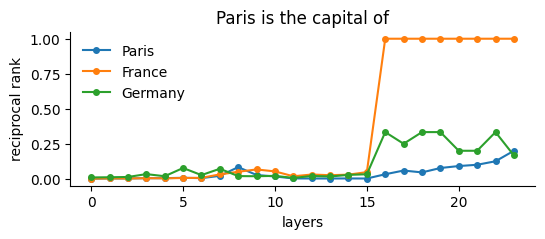

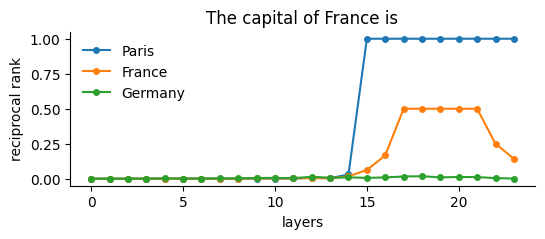

In [16]:
def visualize_token_ranks(scored_tokens, tokens, prompts):
    for prompt_id, prompt_token_ranks in scored_tokens.items():
        all_tokens_ranks = np.array(list(prompt_token_ranks.values()))
        layers = np.array(list(prompt_token_ranks.keys()))
        
        fig, ax = plt.subplots(1, 1, figsize=(6,2), gridspec_kw={'hspace': 0.4})
        labelsize, titlefont, markersize = 10, 12, 8
        
        all_tokens_ranks = np.stack(all_tokens_ranks)
        all_tokens_ranks = np.swapaxes(all_tokens_ranks, 0, 1)
        
        lines = []
        for tokens_ranks in all_tokens_ranks:
            line, = ax.plot(layers, tokens_ranks, marker=".", markersize=markersize)
            lines.append(line)
            
        if tokens is not None:
            ax.legend(lines, tokens, loc='upper left', frameon=False)
        if prompts is not None:
            ax.set_title(prompts[prompt_id], fontsize=titlefont, color="black", loc='center')
            
        ax.set_xlabel('layers',fontsize=labelsize)
        ax.set_ylabel('reciprocal rank',fontsize=labelsize)
        ax.tick_params(axis='both', which='major', labelsize=labelsize)
        #fig.savefig(helpers.ROOT_DIR / "results" / "plots" / "test.pdf", dpi=200, bbox_inches='tight')
    
visualize_token_ranks(scored_tokens, token_candidates, prompts)